In [1]:
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

'''
What we'll need for analysis, clustering, etc.
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

'''
Of course the powerful RDKIT for cheminformatics <3
'''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

'''
Some utilities
'''
#import progressbar
from math import pi

%config Completer.use_jedi = False
PandasTools.RenderImagesInAllDataFrames(images=True)

In [2]:
mols=Chem.SDMolSupplier('all_aligned.sdf')
print (len(mols)) 

30


In [3]:
table=pd.DataFrame()
for i,mol in enumerate(mols):
    Chem.SanitizeMol(mol)
    table.loc[i,'smiles']=Chem.MolToSmiles(mol)
    table.loc[i,'Mol']=mol
    table.loc[i,'MolWt']=Descriptors.MolWt(mol)
    table.loc[i,'LogP']=Descriptors.MolLogP(mol)
    table.loc[i,'NumHAcceptors']=Descriptors.NumHAcceptors(mol)
    table.loc[i,'NumHDonors']=Descriptors.NumHDonors(mol)
    table.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
    table.loc[i,'NumRotatableBonds']=Descriptors.NumRotatableBonds(mol)
    table.loc[i,'NumHeavyAtoms']=Descriptors.HeavyAtomCount (mol)
    table.loc[i,'NumAliphaticCarbocycles']=Descriptors.NumAliphaticCarbocycles(mol)
    table.loc[i,'NumAliphaticHeterocycles']=Descriptors.NumAliphaticHeterocycles(mol)
    table.loc[i,'NumAliphaticRings']=Descriptors.NumAliphaticRings(mol)
    table.loc[i,'NumAromaticCarbocycles']=Descriptors.NumAromaticCarbocycles(mol)
    table.loc[i,'NumAromaticHeterocycles']=Descriptors.NumAromaticHeterocycles(mol)
    table.loc[i,'NumAromaticRings']=Descriptors.NumAromaticRings(mol)
    table.loc[i,'RingCount']=Descriptors.RingCount(mol)
    table.loc[i,'FractionCSP3']=Descriptors.FractionCSP3(mol)
    
    table.loc[i,'TPSA']=Descriptors.TPSA(mol)
    table.loc[i,'NPR1']=rdMolDescriptors.CalcNPR1(mol)
    table.loc[i,'NPR2']=rdMolDescriptors.CalcNPR2(mol)
    table.loc[i,'InertialShapeFactor']=Descriptors3D.InertialShapeFactor(mol)
    table.loc[i,'RadiusOfGyration']=Descriptors3D.RadiusOfGyration(mol)

,smiles,Mol,MolWt,LogP,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumHeavyAtoms,NumAliphaticCarbocycles,...,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,RingCount,FractionCSP3,TPSA,NPR1,NPR2,InertialShapeFactor,RadiusOfGyration
0,COc1cccc(Cn2cc(C(=O)Nc3ccc(C)c(S(=O)(=O)N4CCOC...,,560.676,4.49704,7.0,1.0,10.0,8.0,40.0,0.0,...,3.0,1.0,4.0,5.0,0.266667,102.76,0.285432,0.775200,0.000170,5.581296
1,Cc1ccc(-c2nn(Cc3ccc4ccccc4c3)cc2C(=O)Nc2ccc(C)...,,580.710,5.64164,6.0,1.0,9.0,7.0,42.0,0.0,...,4.0,1.0,5.0,6.0,0.212121,93.53,0.276802,0.809090,0.000160,5.889956
2,Cc1ccc(-c2nn(-c3cccc(Cl)c3)cc2C(=O)Nc2ccc(C)c(...,,551.068,5.08274,6.0,1.0,10.0,6.0,38.0,0.0,...,3.0,1.0,4.0,5.0,0.214286,93.53,0.157718,0.936364,0.000463,5.062917
3,Cc1ccc(-c2nn(-c3ccc(Cl)cc3Cl)cc2C(=O)Nc2ccc(C)...,,585.513,5.73614,6.0,1.0,11.0,6.0,39.0,0.0,...,3.0,1.0,4.0,5.0,0.214286,93.53,0.153339,0.929458,0.000422,5.173126
4,Cc1ccc(-c2nn(-c3nc4ccccc4s3)cc2C(=O)Nc2ccc(C)c...,,573.700,5.03904,8.0,1.0,11.0,6.0,40.0,0.0,...,3.0,2.0,5.0,6.0,0.206897,106.42,0.375347,0.663028,0.000120,5.229281

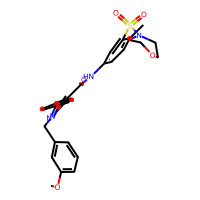
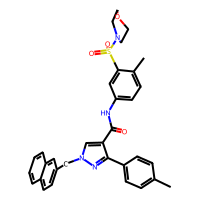
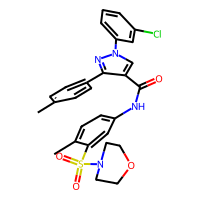
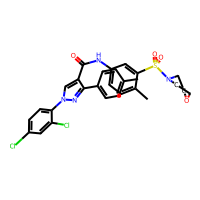
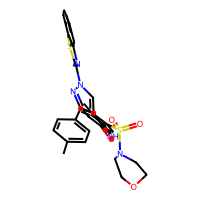

In [4]:
table.head(5)

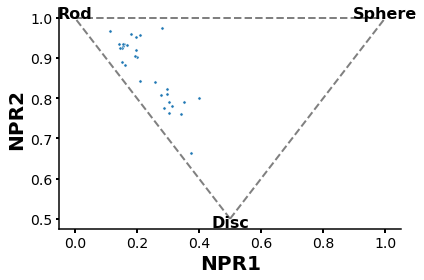

In [5]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(6,4))

ax=sns.scatterplot(x='NPR1',y='NPR2',data=table,s=10,linewidth=0.5,alpha=1)
x1, y1 = [0.5, 0], [0.5, 1]
x2, y2 = [0.5, 1], [0.5, 1]
x3, y3 = [0,1],[1,1]

plt.plot(x1, y1,x2,y2,x3,y3,c='gray',ls='--',lw=2)

plt.xlabel ('NPR1',fontsize=20,fontweight='bold')

plt.ylabel ('NPR2',fontsize=20,fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.text(0, 1.01,s='Rod',fontsize=16,horizontalalignment='center',verticalalignment='center',fontweight='bold')
plt.text(1, 1.01,s='Sphere',fontsize=16,horizontalalignment='center',verticalalignment='center',fontweight='bold')
plt.text(0.5, 0.49,s='Disc',fontsize=16,horizontalalignment='center',verticalalignment='center',fontweight='bold')

plt.tick_params ('both',width=2,labelsize=14)
plt.tight_layout()

plt.show()

In [6]:
descriptors = table[['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'TPSA','RadiusOfGyration']].values #The non-redundant molecular descriptors chosen for PCA
descriptors_std = StandardScaler().fit_transform(descriptors) #Important to avoid scaling problems between our different descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)
descriptors_pca= pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = table.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
descriptors_pca.head(5) #Displays the PCA table

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-1.522462,-0.212294,0.366418,-0.518883,-0.647666,-0.205013,0.011797
1,-2.860808,1.825296,0.543280,-0.855285,-1.249753,0.073189,-0.135113
2,-1.334664,1.153891,0.306883,0.056511,0.204380,-0.315865,0.042303
3,-2.308188,0.994268,-0.422961,0.214210,0.611901,-0.438122,0.047643
4,-2.850482,-0.013331,1.036437,-0.717510,0.590087,0.513160,-0.288411


In [7]:
print(pca.explained_variance_ratio_) #Let's plot PC1 vs PC2 
print(sum(pca.explained_variance_ratio_))

[0.53401717 0.20320831 0.12130967 0.06942024 0.05826752 0.01005921
 0.00371789]
0.9999999999999998


In [8]:
# This normalization will be performed just for PC1 and PC2, but can be done for all the components.
#The normalization is to plot PCA values in 0-1 sacle and include the vectors (features to the plot)

scale1 = 1.0/(max(descriptors_pca['PC1']) - min(descriptors_pca['PC1'])) 
scale2 = 1.0/(max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

# And we add the new values to our PCA table
descriptors_pca['PC1_normalized']=[i*scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized']=[i*scale2 for i in descriptors_pca['PC2']]

In [9]:
descriptors_pca.head(5) # The PCA table now has the normalized PC1 and PC2

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC1_normalized,PC2_normalized
0,-1.522462,-0.212294,0.366418,-0.518883,-0.647666,-0.205013,0.011797,-0.225219,-0.039432
1,-2.860808,1.825296,0.543280,-0.855285,-1.249753,0.073189,-0.135113,-0.423201,0.339036
2,-1.334664,1.153891,0.306883,0.056511,0.204380,-0.315865,0.042303,-0.197438,0.214327
3,-2.308188,0.994268,-0.422961,0.214210,0.611901,-0.438122,0.047643,-0.341451,0.184678
4,-2.850482,-0.013331,1.036437,-0.717510,0.590087,0.513160,-0.288411,-0.421673,-0.002476


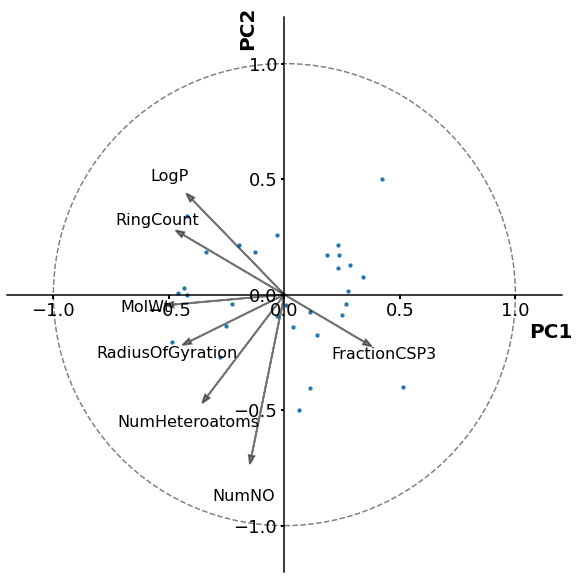

In [10]:
plt.rcParams['axes.linewidth'] = 1.5
plt.figure(figsize=(8,8))

ax=sns.scatterplot(x='PC1_normalized',y='PC2_normalized',data=descriptors_pca,s=20,palette=sns.color_palette("Set2", 3),linewidth=0.2,alpha=1)

plt.xlabel ('PC1',fontsize=20,fontweight='bold')
ax.xaxis.set_label_coords(0.98, 0.45)
plt.ylabel ('PC2',fontsize=20,fontweight='bold')
ax.yaxis.set_label_coords(0.45, 0.98)

ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


lab=['MolWt', 'LogP','NumHeteroatoms','RingCount','FractionCSP3', 'NumNO', 'RadiusOfGyration'] #Feature labels

l=np.transpose(pca.components_[0:2, :]) ## We will get the components eigenvectors (main features) for PC1 and PC2

n = l.shape[0]
for i in range(n):
    plt.arrow(0, 0, l[i,0], l[i,1],color= 'k',alpha=0.5,linewidth=1.8,head_width=0.025)
    plt.text(l[i,0]*1.25, l[i,1]*1.25, lab[i], color = 'k',va = 'center', ha = 'center',fontsize=16)

circle = plt.Circle((0,0), 1, color='gray', fill=False,clip_on=True,linewidth=1.5,linestyle='--')

plt.tick_params ('both',width=2,labelsize=18)

ax.add_artist(circle)
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tight_layout()
plt.show()

In [11]:
smiles = list(table["smiles"])
smi=[Chem.MolFromSmiles(x) for x in smiles]
fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # In this example I'll use MACCSKeys
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps) #This compute a similartity matrix between all the molecules
n_mol = len(fps)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
distance_matrix = np.subtract(1,similarity_matrix) #This is the similarity matrix of all vs all molecules in our table

In [12]:
TSNE_sim = TSNE(n_components=2,init='pca',random_state=90, angle = 0.3, perplexity=5).fit_transform(distance_matrix) #Remember to always tune the parameters acording your dataset!!
tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) # New table containing the tSNE results
tsne_result.head(5) #A new table containing the tSNE results

,TC1,TC2
0,160.103394,159.068375
1,9.949471,-51.927044
2,-267.092590,-42.390919
3,-273.908447,-22.048452
4,-22.663448,-3.518037


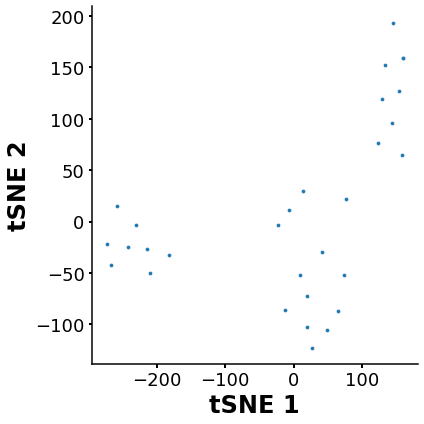

In [13]:
plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(6,6))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result,s=15,linewidth=0.2,alpha=1)
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

plt.tight_layout()
plt.show()

In [14]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10] # To explore the "best" number of cluster to clasify our molecules
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(tsne_result[['TC1','TC2']])
    silhouette_avg = silhouette_score(tsne_result[['TC1','TC1']], cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg) #This will print the silhouette score, as higher as our data is better distributed inside the clusters

C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.780207
For n_clusters = 3 The average silhouette_score is : 0.7589643


C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

For n_clusters = 4 The average silhouette_score is : 0.4688443
For n_clusters = 5 The average silhouette_score is : 0.24014854


C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

For n_clusters = 6 The average silhouette_score is : 0.1967539
For n_clusters = 7

C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


 The average silhouette_score is : 0.12154567
For n_clusters = 8 The average silhouette_score is : 0.044304933


C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

For n_clusters = 9 The average silhouette_score is : 0.062069733
For n_clusters = 10 The average silhouette_score is : 0.03350341


C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [15]:
kmeans = KMeans(n_clusters=4, random_state=10) # We define the best number of clusters (6)
clusters = kmeans.fit(tsne_result[['TC1','TC2']]) #TC1vs TC2

tsne_result['Cluster'] = pd.Series(clusters.labels_+1, index=tsne_result.index)
tsne_result.head(4) #The tSNE table now contains the numer of cluster for each element

C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\amitc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,TC1,TC2,Cluster
0,160.103394,159.068375,1
1,9.949471,-51.927044,4
2,-267.092590,-42.390919,2
3,-273.908447,-22.048452,2


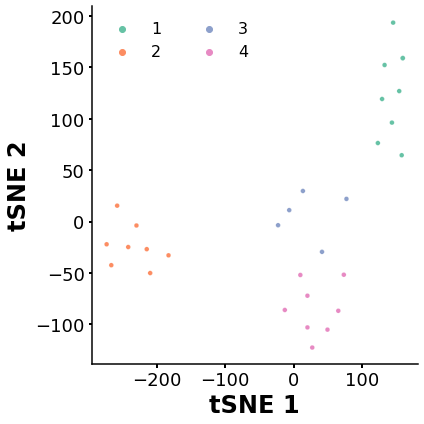

In [16]:
plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(6,6))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result, hue='Cluster',s=22,palette=sns.color_palette("Set2", 4),linewidth=0.2,alpha=1)
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles[1:], labels=labels[1:])

plt.legend(loc='best',frameon=False,prop={'size': 16},ncol=2)

plt.tight_layout()
plt.show()

In [26]:
distance_matrix

array([[0.        , 0.16129032, 0.5       , ..., 0.7       , 0.6875    ,
        0.63934426],
       [0.16129032, 0.        , 0.47169811, ..., 0.74074074, 0.70588235,
        0.56666667],
       [0.5       , 0.47169811, 0.        , ..., 0.7972973 , 0.77464789,
        0.27419355],
       ...,
       [0.7       , 0.74074074, 0.7972973 , ..., 0.        , 0.15      ,
        0.71232877],
       [0.6875    , 0.70588235, 0.77464789, ..., 0.15      , 0.        ,
        0.75675676],
       [0.63934426, 0.56666667, 0.27419355, ..., 0.71232877, 0.75675676,
        0.        ]])

In [11]:
l.shape

(7, 2)